In [1]:
import torch
import random
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

import torch.nn as nn
import torch.nn.functional as F

import math
import time

/scratch/cluster/bodeng/miniconda3/envs/dip/lib/python3.9/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda:6' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:6


# 1. Load the data and get measurements

In [3]:
ROOT_PATH = "/scratch/cluster/bodeng/UTAFSDataNew/new_data"
CHIP_NUM = 14

In [4]:
import utils

data_dict = utils.grab_chip_data(ROOT_PATH, CHIP_NUM)

In [5]:
data_dict.keys()

dict_keys(['gt_matrix', 'gt_freqs', 'vf_matrix', 'y_matrix', 'y_freqs'])

## Convert the raw data matrices to only the unique S-parameters

In [6]:
vf_data = utils.matrix_to_sparams(data_dict['vf_matrix'])
gt_data = utils.matrix_to_sparams(data_dict['gt_matrix'])
y_data = utils.matrix_to_sparams(data_dict['y_matrix'])

print("VF S-parameters shape: ", vf_data.shape)
print("GT S-parameters shape: ", gt_data.shape)
print("Y S-parameters shape: ", y_data.shape)

VF S-parameters shape:  (10, 2, 500)
GT S-parameters shape:  (10, 2, 500)
Y S-parameters shape:  (10, 2, 19)


In [7]:
gt_freqs = data_dict['gt_freqs']
y_freqs = data_dict['y_freqs']

print("GT frequencies shape: ", gt_freqs.shape)
print("Y frequencies shape: ", y_freqs.shape)

GT frequencies shape:  (500,)
Y frequencies shape:  (19,)


In [8]:
import scipy as sp

spacings = gt_freqs[1:] - gt_freqs[:-1]

mode_spacing = sp.stats.mode(spacings, keepdims=False)[0]
num_mode = len(np.where(spacings==mode_spacing)[0])

print("First frequency point: ", gt_freqs[0])
print("Mean frequency spacing: ", np.mean(spacings))
print("STD frequency spacing: ", np.std(spacings))
print("Mode frequency spacing: ", mode_spacing)
print("Number of samples with non-equal spacing: ", len(gt_freqs) - num_mode)

First frequency point:  100000000.0
Mean frequency spacing:  39879759.51903807
STD frequency spacing:  34.77371940703715
Mode frequency spacing:  39879760.0
Number of samples with non-equal spacing:  275


In [9]:
#NOTE THIS IS EXPERIMENTAL!!!
if gt_freqs[0] == 0:
    gt_freqs = gt_freqs[1:]
    gt_data = gt_data[:, :, 1:]

## Make some variables we will need

In [10]:
N_FREQS = gt_data.shape[-1]
N_SPARAMS = gt_data.shape[0]  

print("N_FREQS: ", N_FREQS)
print("N_SPARAMS: ", N_SPARAMS)

N_FREQS:  500
N_SPARAMS:  10


In [11]:
x = torch.from_numpy(gt_data).view(-1, N_FREQS).unsqueeze(0).to(device)

print("x shape: ", x.shape)

x shape:  torch.Size([1, 20, 500])


In [12]:
x_mag = utils.sparams_to_mag(x)

print("x_mag shape: ", x_mag.shape)

x_mag shape:  torch.Size([1, 10, 500])


## Plot some stuff

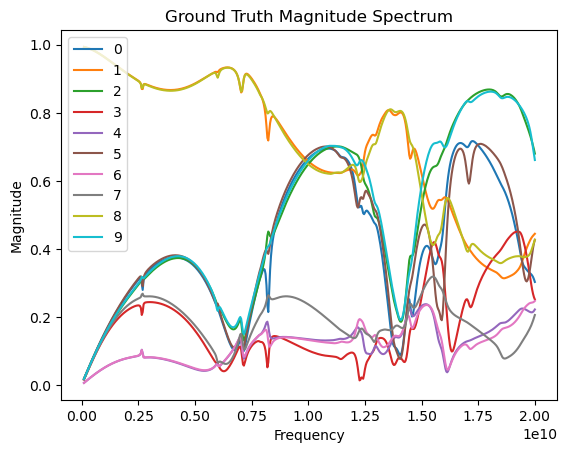

In [13]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x_mag[0, i].cpu(), label=str(i))
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Magnitude Spectrum")
plt.ylabel("Magnitude")
plt.xlabel("Frequency")
plt.show()

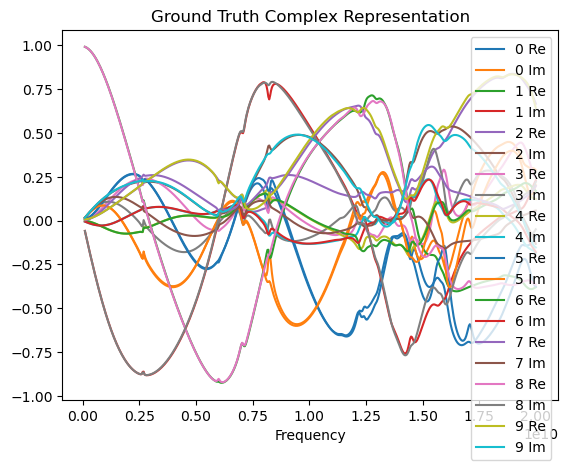

In [14]:
plt.figure()
for i in range(N_SPARAMS):
    plt.plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" Re")
    plt.plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" Im")
if N_SPARAMS <= 10:
    plt.legend()
plt.title("Ground Truth Complex Representation")
plt.xlabel("Frequency")
plt.show()

## Grab Some Measurements

In [15]:
PROBLEM_TYPE = "sqrt" #[random, equal, forecast, full, log, sqrt]
M = 19

kept_inds, missing_inds = utils.get_inds(PROBLEM_TYPE, N_FREQS, M)

M = len(kept_inds) #re-define in case kept_inds is off by 1 or something

print("Number of Ground Truth Frequency Points: ", N_FREQS)
print("Number of Measurements: ", M)
print("Undersampling Ratio: ", M/N_FREQS)

Number of Ground Truth Frequency Points:  500
Number of Measurements:  19
Undersampling Ratio:  0.038


In [16]:
y = torch.clone(x)[:, :, kept_inds]
y_freqs = gt_freqs[kept_inds]

print("y shape: ", y.shape)
print("y_freqs shape: ", y_freqs.shape)

y shape:  torch.Size([1, 20, 19])
y_freqs shape:  (19,)


# 2. Network Setup

## Define network parameters

In [17]:
NZ = y.shape[1]

NUM_LAYERS = int(np.ceil(np.log2(N_FREQS))) - 4

if NZ < 64:
    BASE_NGF = 2 ** (int(np.ceil(np.log2(NZ))) + 1) #second power of two after NZ 
elif NZ < 128:
    BASE_NGF = 2 ** int(np.ceil(np.log2(NZ))) #next highest power of 2
else:
    BASE_NGF = NZ
NGF = [BASE_NGF] * NUM_LAYERS

BS = y.shape[0]
NC = y.shape[1]

KERNEL_SIZE = 3
USE_SKIP = False
CAUSAL_PASSIVE = True
OPTIMIZE_Z = False

In [18]:
print("NZ: ", str(NZ))
print("NUM_LAYERS: ", str(NUM_LAYERS))
print("BASE NGF: ", str(BASE_NGF))
print("NGF: ", str(NGF))
print("BS: ", BS)
print("NC: ", NC)
print("KERNEL_SIZE: ", KERNEL_SIZE)
print("USE_SKIP: ", USE_SKIP)
print("CAUSAL_PASSIVE: ", CAUSAL_PASSIVE)
print("OPTIMIZE_Z: ", OPTIMIZE_Z)

NZ:  20
NUM_LAYERS:  5
BASE NGF:  64
NGF:  [64, 64, 64, 64, 64]
BS:  1
NC:  20
KERNEL_SIZE:  3
USE_SKIP:  False
CAUSAL_PASSIVE:  True
OPTIMIZE_Z:  False


## Init and check dimensions

In [19]:
from models import RES_UNET

net = RES_UNET(bs=BS,
               nz=NZ,
               ngf=NGF,
               output_size=N_FREQS,
               nc=NC,
               optimize_z=OPTIMIZE_Z,
               kernel_size=KERNEL_SIZE,
               num_layers=NUM_LAYERS,
               use_skip=USE_SKIP,
               causal_passive=CAUSAL_PASSIVE)
net = net.to(device)

In [20]:
test_out = net.forward_with_z()

print("Net output shape: ", test_out.shape)

Net output shape:  torch.Size([1, 20, 500])


In [21]:
pytorch_total_params = sum(p.numel() for p in net.parameters() if p.requires_grad)

print("TOTAL PARAMS: ", pytorch_total_params)

TOTAL PARAMS:  283848


# 3. Run

## Define training parameters, losses, and track stats

In [22]:
LR = 2e-4 
NUM_ITER = 20000 

REG_HYPERPARAM = 1.0

In [23]:
NOISY_INPUT = True

START_NOISE_LEVEL = CUR_NOISE_LEVEL = 10
END_NOISE_LEVEL = 0.001
NOISE_DECAY_FACTOR = (END_NOISE_LEVEL / START_NOISE_LEVEL)**(1 / NUM_ITER) 

print("Noise decay factor: ", NOISE_DECAY_FACTOR)

Noise decay factor:  0.9995395890030878


In [24]:
criterion = utils.Measurement_MSE_Loss(kept_inds=kept_inds, per_param=False, reduction="sum")
criterion = criterion.to(device)

if REG_HYPERPARAM > 0:
    regularizer = utils.Smoothing_Loss(per_param=False, reduction="sum")
    regularizer = regularizer.to(device)

In [25]:
net = net.train()

optim = torch.optim.Adam(net.parameters(), lr=LR)

In [26]:
train_losses = []
train_errors = []
if REG_HYPERPARAM > 0:
    train_regs = []

test_mses = []
test_maes = []

## Train DIP

In [27]:
tic = time.time()

for i in range(NUM_ITER):
    optim.zero_grad()
    
    if NOISY_INPUT:
        out = net.forward_with_z(CUR_NOISE_LEVEL)
        CUR_NOISE_LEVEL *= NOISE_DECAY_FACTOR
    else:
        out = net.forward_with_z()
    
    train_error = criterion(out, y) 
    if REG_HYPERPARAM > 0:
        train_reg = REG_HYPERPARAM * regularizer(out)
        train_loss = train_error + train_reg
    else:
        train_loss = train_error
    
    train_loss.backward()
    optim.step()
    
    with torch.no_grad():
        train_losses.append(train_loss.item())
        train_errors.append(train_error.item())
        if REG_HYPERPARAM > 0:
            train_regs.append(train_reg.item())
        
        test_mse = nn.MSELoss()(out, x)
        test_mses.append(test_mse.item())
        
        test_mae = nn.L1Loss()(out, x)
        test_maes.append(test_mae.item())

        if (i+1)%1000 == 0 or i == 0:
            toc = time.time()
            print("ITER ", str(i))
            print("TIME: ", str(toc - tic))
            if NOISY_INPUT:
                print("NOISE LEVEL: ", CUR_NOISE_LEVEL)
            print()

ITER  0
TIME:  20.73770833015442
NOISE LEVEL:  9.995395890030878

ITER  999
TIME:  40.132166624069214
NOISE LEVEL:  6.309573444801721

ITER  1999
TIME:  57.80094075202942
NOISE LEVEL:  3.981071705534711

ITER  2999
TIME:  76.19724869728088
NOISE LEVEL:  2.511886431509337

ITER  3999
TIME:  94.44674301147461
NOISE LEVEL:  1.5848931924609126

ITER  4999
TIME:  112.34105134010315
NOISE LEVEL:  0.9999999999998402

ITER  5999
TIME:  130.34315633773804
NOISE LEVEL:  0.630957344480072

ITER  6999
TIME:  148.3988654613495
NOISE LEVEL:  0.398107170553409

ITER  7999
TIME:  167.16757607460022
NOISE LEVEL:  0.25118864315089406

ITER  8999
TIME:  184.84340357780457
NOISE LEVEL:  0.15848931924606569

ITER  9999
TIME:  202.89612889289856
NOISE LEVEL:  0.09999999999996798

ITER  10999
TIME:  221.9567904472351
NOISE LEVEL:  0.06309573444799713

ITER  11999
TIME:  240.30646085739136
NOISE LEVEL:  0.03981071705533446

ITER  12999
TIME:  258.6530029773712
NOISE LEVEL:  0.025118864315085362

ITER  13999
T

## Plot metrics and outputs

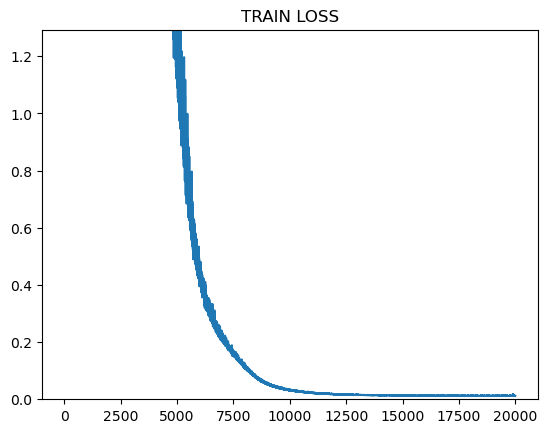

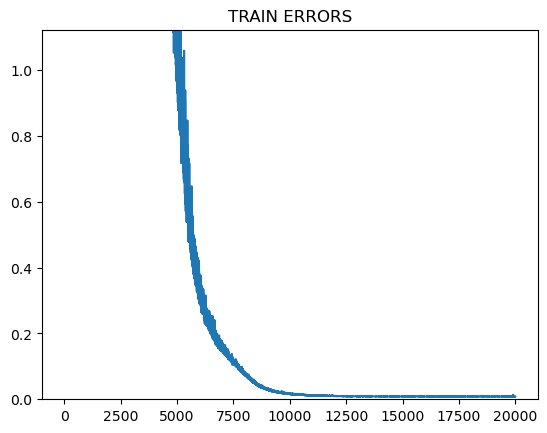

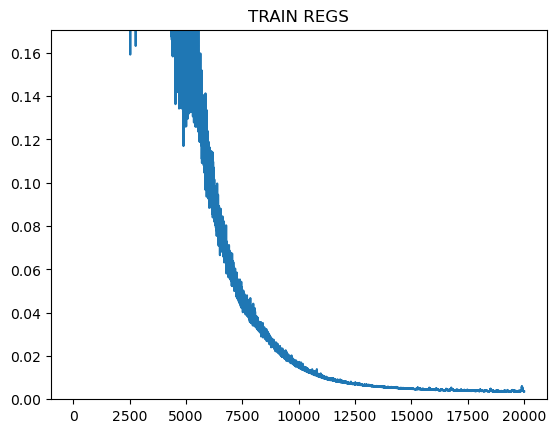

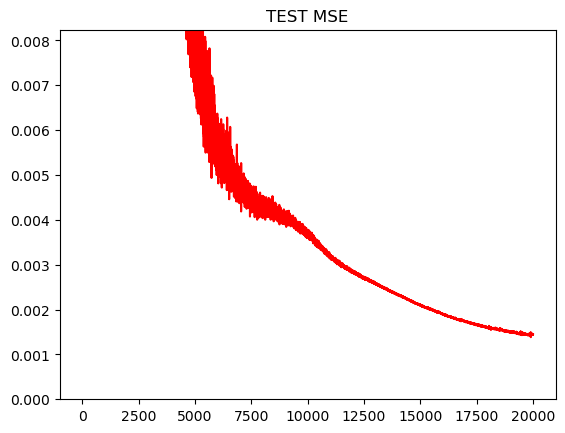

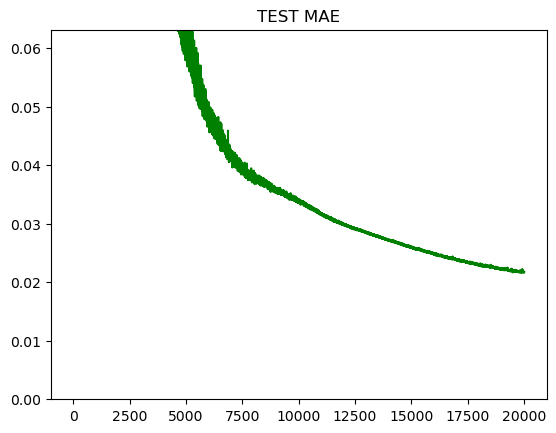

In [28]:
max_idx = 5000

plt.figure()
plt.plot(train_losses)
plt.title("TRAIN LOSS")
plt.ylim(0., train_losses[max_idx])
plt.show()

plt.figure()
plt.plot(train_errors)
plt.title("TRAIN ERRORS")
plt.ylim(0., train_errors[max_idx])
plt.show()

if REG_HYPERPARAM > 0:
    plt.figure()
    plt.plot(train_regs)
    plt.title("TRAIN REGS")
    plt.ylim(0., train_regs[max_idx])
    plt.show()

plt.figure()
plt.plot(test_mses, color='r')
plt.title("TEST MSE")
plt.ylim(0., test_mses[max_idx])
plt.show()

plt.figure()
plt.plot(test_maes, color='g')
plt.title("TEST MAE")
plt.ylim(0, test_maes[max_idx])
plt.show()

In [29]:
print("Final Test MSE: ", test_mses[-1])
print("Best Test MSE: ", np.min(test_mses))
print("Best Test MSE Iteration: ", np.argmin(test_mses))

Final Test MSE:  0.0014451431343331933
Best Test MSE:  0.0013847636291757226
Best Test MSE Iteration:  19898


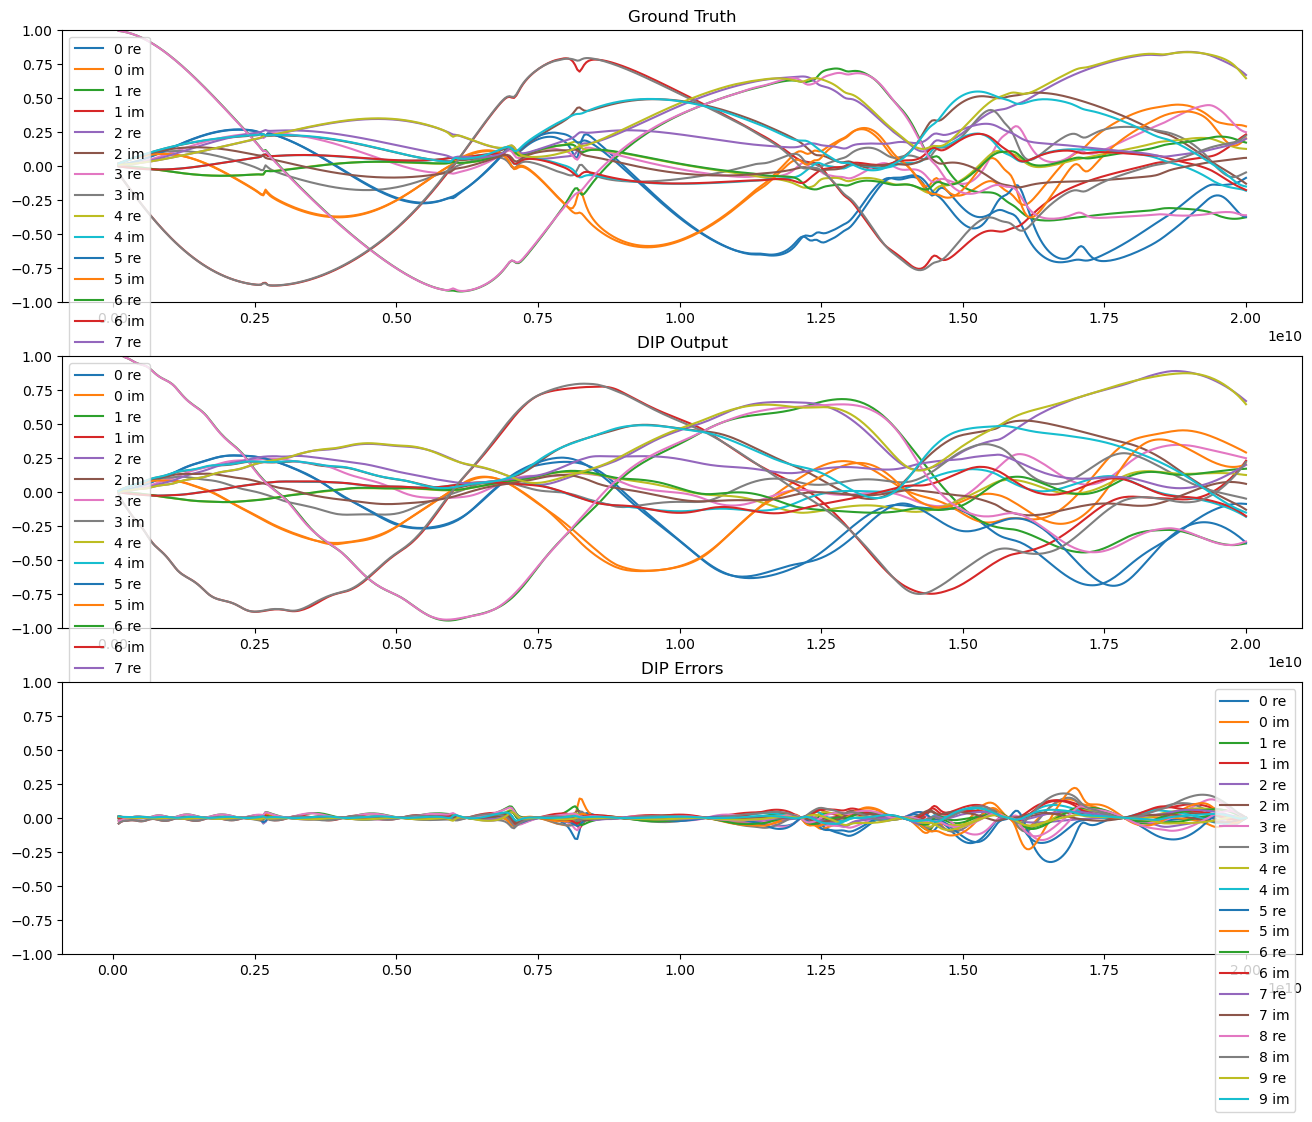

In [30]:
dip_errors = x - out

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

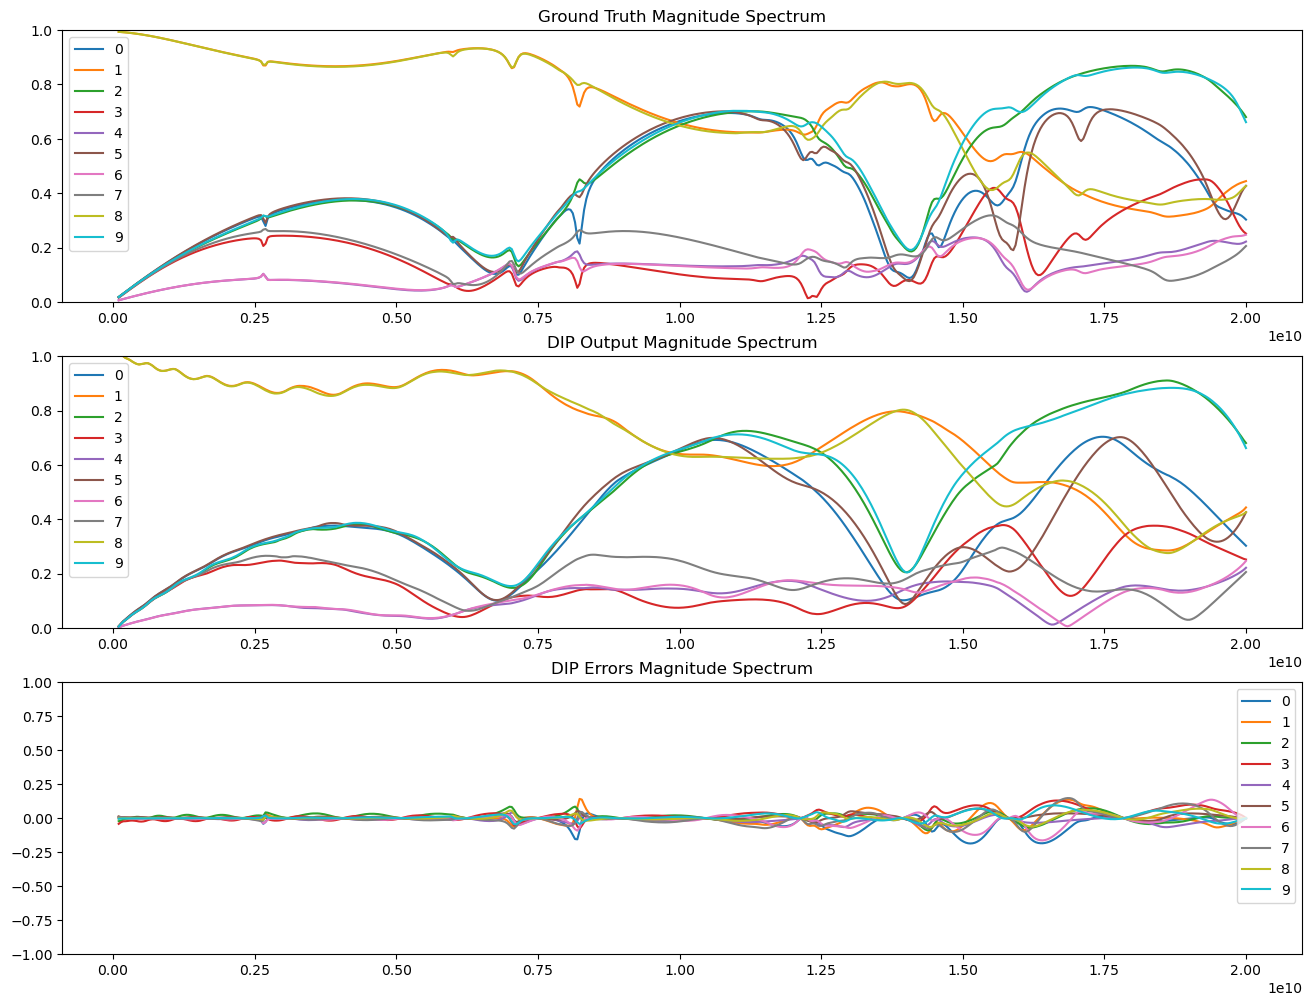

In [31]:
out_mag = utils.sparams_to_mag(out)
dip_errors_mag = x_mag - out_mag 

fig, axes = plt.subplots(3,1, figsize=(16, 12))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x_mag[0,i].cpu(), label=str(i))
axes[0].set_title("Ground Truth Magnitude Spectrum")
axes[0].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[0].legend()

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out_mag[0,i].detach().cpu(), label=str(i))
axes[1].set_title("DIP Output Magnitude Spectrum")
axes[1].set_ylim(0,1)
if N_SPARAMS <= 10:
    axes[1].legend()
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,i].detach().cpu(), label=str(i))
axes[2].set_title("DIP Errors Magnitude Spectrum")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend()

In [32]:
# Make the VF Solution and use it as input to network
import VF.vectorfit
import os

LENGTH = len(gt_freqs)

cn = str(CHIP_NUM) if CHIP_NUM > 9 else "0" + str(CHIP_NUM)
fname = os.path.join(ROOT_PATH, "case"+cn)

children = os.listdir(fname)
children = [f for f in children if cn + ".s" in f]

final_path = os.path.join(fname, children[0])

print(final_path)

fitter = VF.vectorfit.VectorFitter(final_path)
fit1 = fitter.vector_fit("VF Result", y_freqs) 
vf_output = fit1.fitted_network.s
print(vf_output.shape)
print(vf_output.dtype)
vf_data = np.stack((vf_output.real, vf_output.imag), axis=-1)
vf_data = utils.matrix_to_sparams(vf_data)
vf_data = torch.tensor(vf_data).view(1, -1, LENGTH)
vf_data = vf_data.to(device)

print(vf_data.shape)
## Make neworks from DIP, Interp, and Observations
DIP_OUT_MATRIX = utils.sparams_to_matrix(out)
VF_MATRIX = utils.sparams_to_matrix(vf_data)
Y_MATRIX = utils.sparams_to_matrix(y)

print(DIP_OUT_MATRIX.shape)
print(VF_MATRIX.shape)
print(Y_MATRIX.shape)

DIP_net = utils.matrix_to_network(DIP_OUT_MATRIX, gt_freqs, "DIP Recon With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
VF_net = utils.matrix_to_network(VF_MATRIX, gt_freqs, "Vector Fit With "+str(M)+" Samples for Chip "+str(CHIP_NUM))
Y_net = utils.matrix_to_network(Y_MATRIX, y_freqs, "Observations for Chip "+str(CHIP_NUM))

## Grab the data back from the networks for DIP and Interp to compare metrics
DIP_FINAL_OUT = np.stack((DIP_net.s.real, DIP_net.s.imag), axis=-1)
VF_FINAL_OUT = np.stack((VF_net.s.real, VF_net.s.imag), axis=-1)

print(DIP_FINAL_OUT.shape)
print(VF_FINAL_OUT.shape)

dip_data = utils.matrix_to_sparams(DIP_FINAL_OUT)
vf_mat = utils.matrix_to_sparams(VF_FINAL_OUT)

print(dip_data.shape)
print(vf_mat.shape)
print(dip_data.dtype)
print(vf_mat.dtype)

## Compare DIP, VF, and Interp
import skimage.metrics
from skimage.metrics import peak_signal_noise_ratio as psnr

psnr_ours = psnr(gt_data, dip_data)
psnr_vf = psnr(gt_data, vf_mat)

print("DIP MSE: ", test_mses[-1])
print("VF MSE: ", torch.nn.MSELoss()(x, vf_data).item())
print("DIP PSNR: ", psnr_ours)
print("VF PSNR: ", psnr_vf)

/scratch/cluster/bodeng/UTAFSDataNew/new_data/case14/case14.s4p
Performing fit with 1 poles.


/u/bodeng/CurveFitting-DIP/VF/vectorfit.py:227: UserWarning: The fitted network is passive, but the vector fit is not passive. Consider running `passivity_enforce()` to enforce passivity before using this model.
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 3.2406243085861206 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
Performing fit with 2 poles.
  Fitting took 0.017631299793720245 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 2 (err 0.09822351719918898 vs 0.16392820648677286)
Performing fit with 3 poles.
  Fitting took 0.7064001057296991 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 4 poles better than 4 (err 0.0820640824901414 vs 0.09822351719918898)
Performing fit with 4 poles.
  Fitting took 0.5870977751910686 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 5 poles better than 4 (err 0.06842251934502573 vs 0.0820640824901414)
Performing fit with 5 poles.
  Fitting took 0.8865680005401373 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 7 poles better than 5 (err 0.002

/u/bodeng/CurveFitting-DIP/VF/vectorfit.py:227: RuntimeWarning: Vector Fitting: The pole relocation process stopped after reaching the maximum number of iterations (N_max = 100). The results did not converge properly. 
  vf.vector_fit(n_poles_cmplx=n_poles)


  Fitting took 0.9581937212496996 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 8 poles better than 7 (err 0.0019403831488646773 vs 0.0029021128615095643)
Performing fit with 7 poles.
  Fitting took 0.39180630445480347 seconds.
  Filling sampled network.
  Filling full sweep network.
  Computing error.
  Fit with 9 poles better than 8 (err 0.0007424023012523503 vs 0.0019403831488646773)
Fit completed in 7.685529470443726, using 7, resulting in a fit with 9 and error=0.0007424023012523503 vs samples and error=0.18689243294573563 vs ground truth.
(500, 4, 4)
complex128
torch.Size([1, 20, 500])
torch.Size([500, 4, 4, 2])
torch.Size([500, 4, 4, 2])
torch.Size([19, 4, 4, 2])
(500, 4, 4, 2)
(500, 4, 4, 2)
(10, 2, 500)
(10, 2, 500)
float32
float32
DIP MSE:  0.0014451431343331933
VF MSE:  0.0011689761886373162
DIP PSNR:  34.421491286454305
VF PSNR:  35.34254324464848


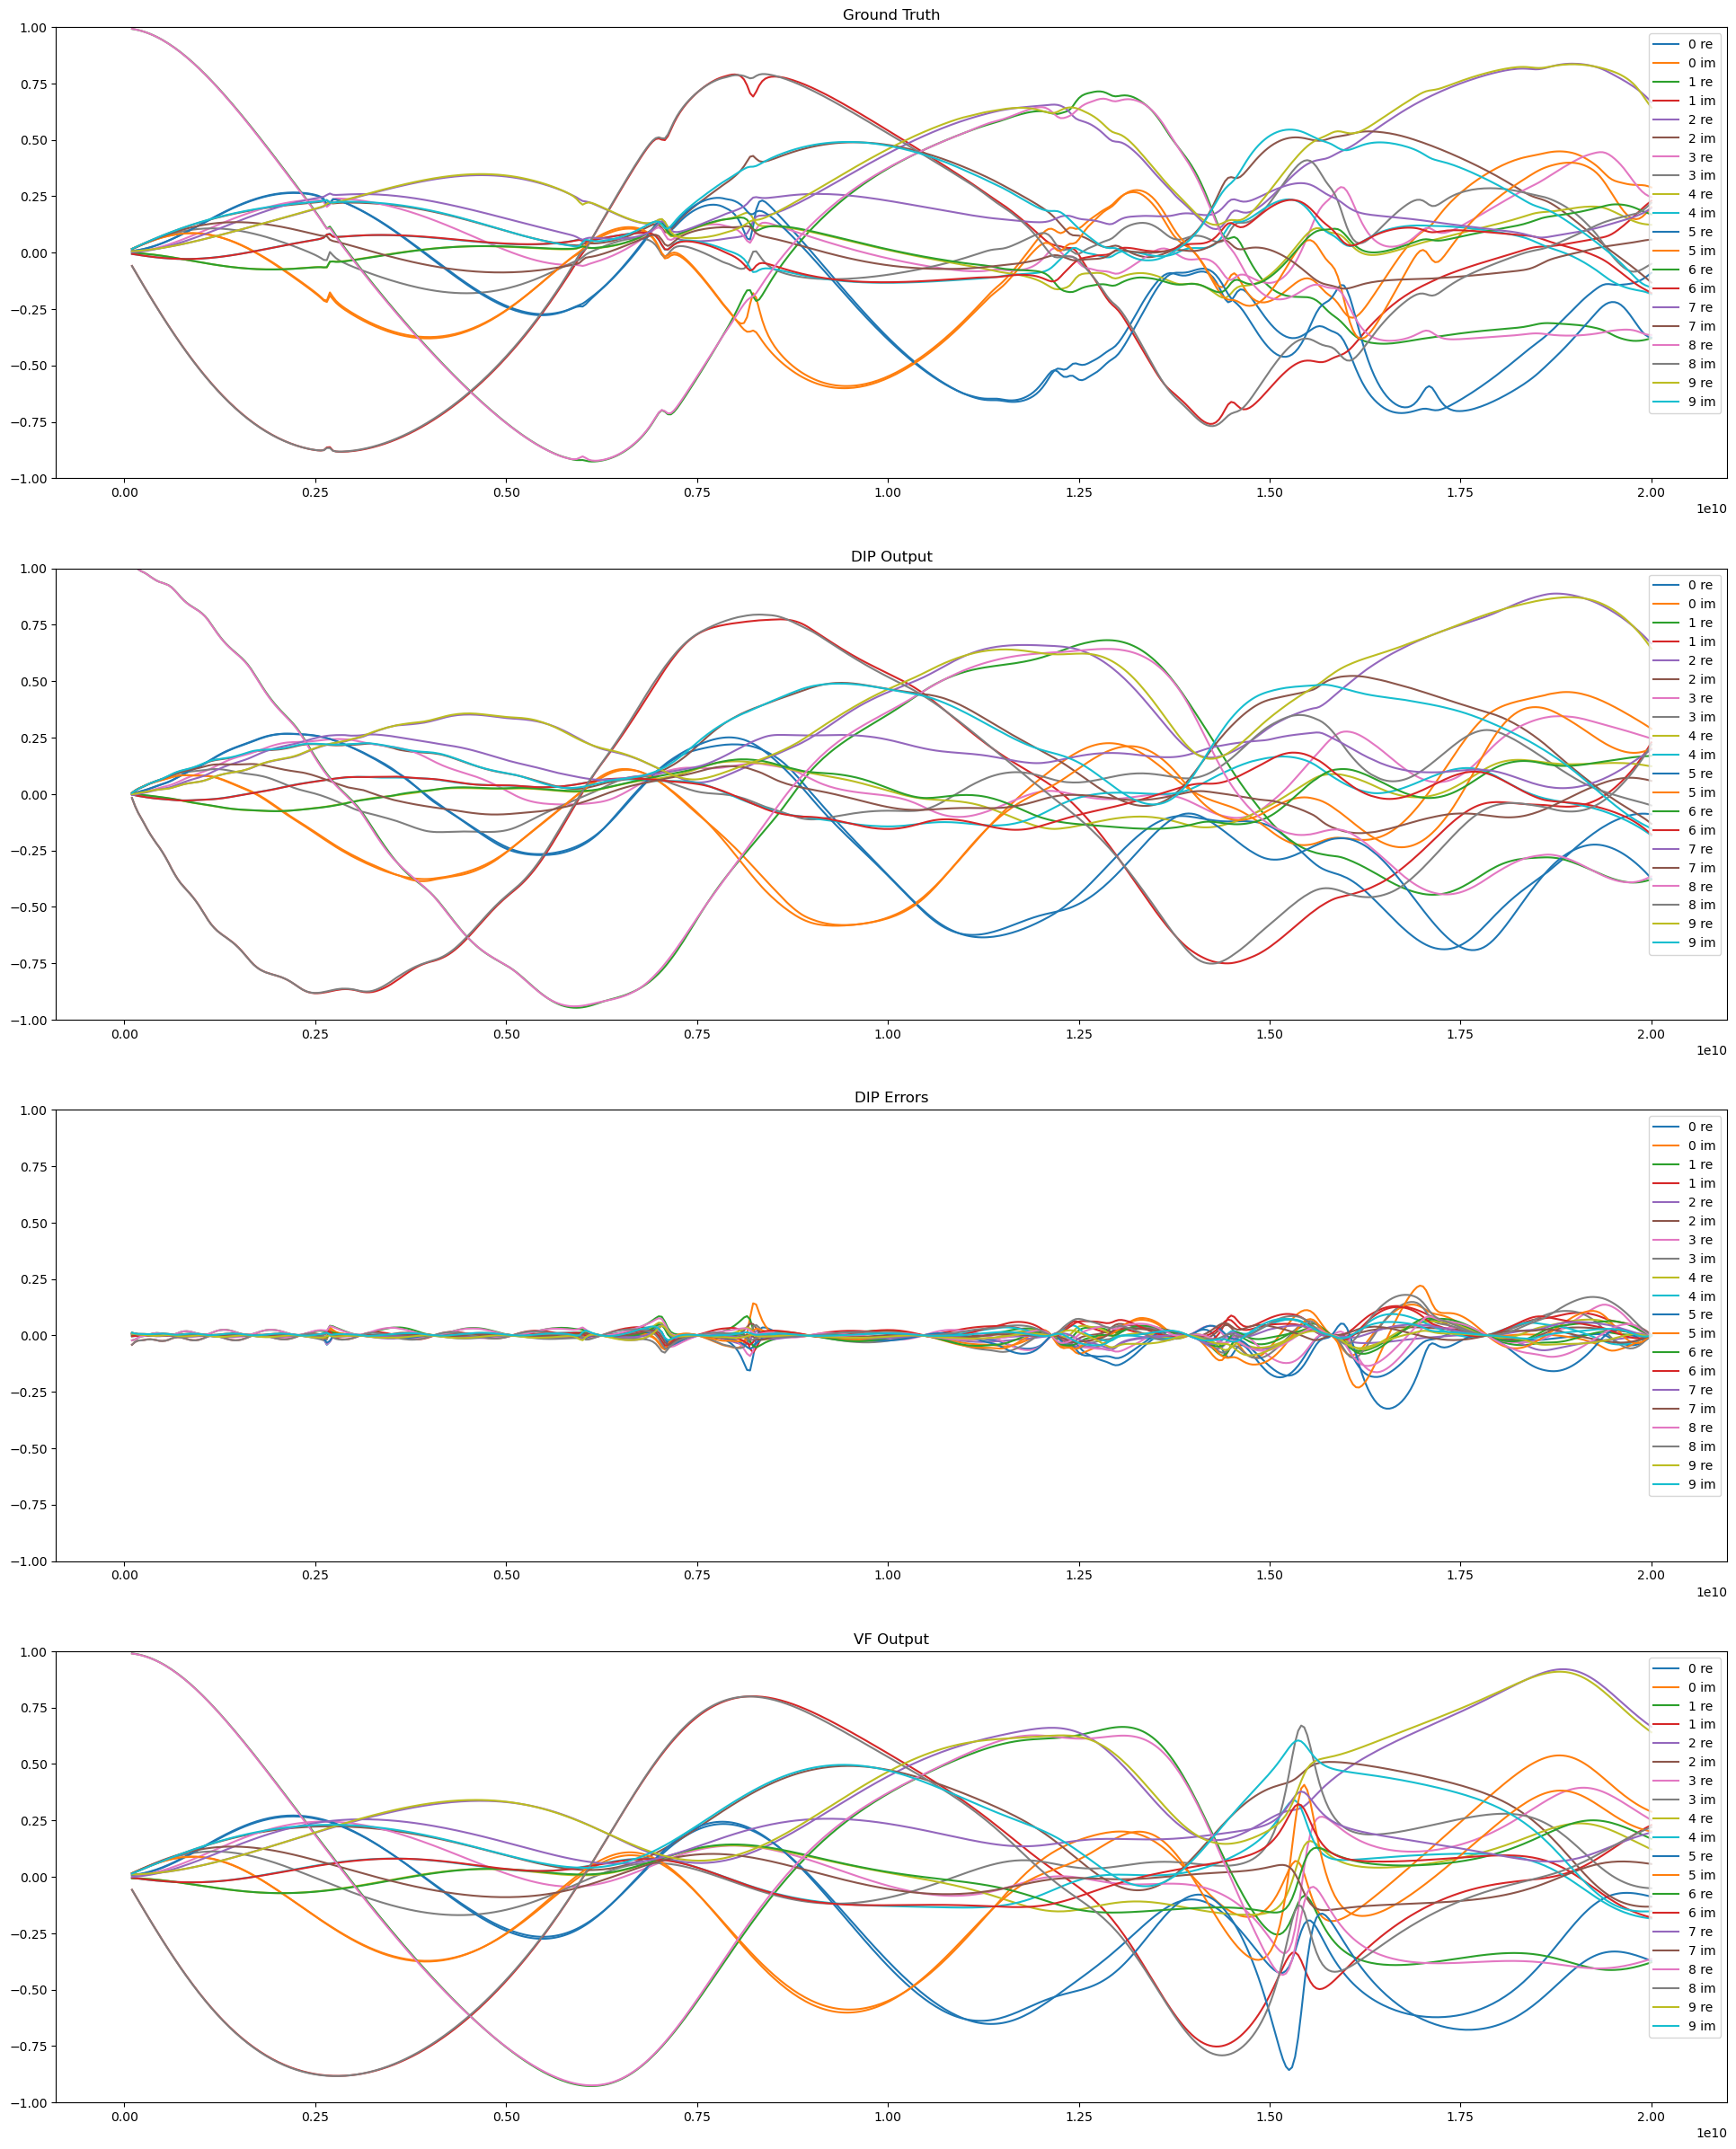

In [33]:
dip_errors = x - out

fig, axes = plt.subplots(4,1, figsize=(24, 30))
axes = axes.flatten()

for i in range(N_SPARAMS):
    axes[0].plot(gt_freqs, x[0,2*i].cpu(), label=str(i)+" re")
    axes[0].plot(gt_freqs, x[0,2*i+1].cpu(), label=str(i)+" im")
axes[0].set_title("Ground Truth")
axes[0].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[0].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[1].plot(gt_freqs, out[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[1].plot(gt_freqs, out[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[1].set_title("DIP Output")
axes[1].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[1].legend(loc='upper right')
    
for i in range(N_SPARAMS):
    axes[2].plot(gt_freqs, dip_errors[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[2].plot(gt_freqs, dip_errors[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[2].set_title("DIP Errors")
axes[2].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[2].legend(loc='upper right')

for i in range(N_SPARAMS):
    axes[3].plot(gt_freqs, vf_data[0,2*i].detach().cpu(), label=str(i)+" re")
    axes[3].plot(gt_freqs, vf_data[0,2*i+1].detach().cpu(), label=str(i)+" im")
axes[3].set_title("VF Output")
axes[3].set_ylim(-1,1)
if N_SPARAMS <= 10:
    axes[3].legend(loc='upper right')